Total Images: 159
Running segmentation...


100%|██████████| 30/30 [00:18<00:00,  1.62it/s]





--- K-Means ---
Boundary F1 : 0.8734468582177917

--- Fuzzy C-Means ---
Boundary F1 : 0.8715355156310353


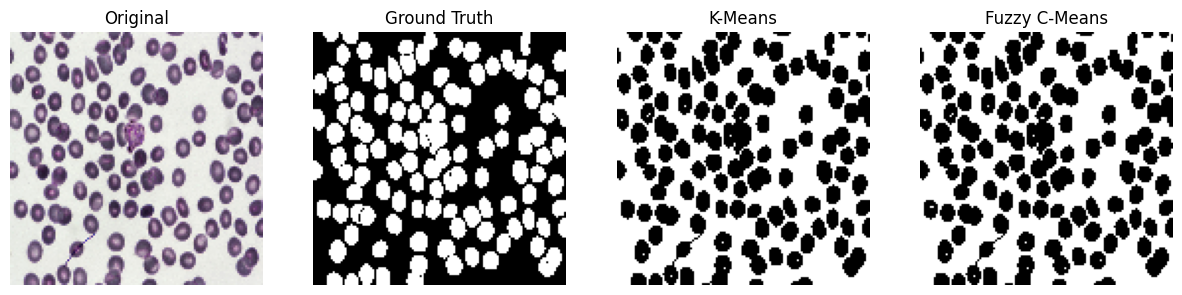

In [1]:

# WHITE BLOOD CELL SEGMENTATION
# K-Means vs Manual Fuzzy C-Means
# Boundary Accuracy Only


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


# DATASET PATH 
DATA_PATH = "/kaggle/input/bccd-dataset-with-mask"
IMAGE_DIR = "/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/test/original"
MASK_DIR = "/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/test/mask"

image_files = sorted(os.listdir(IMAGE_DIR))

print("Total Images:", len(image_files))


def load_image_mask(image_name):
    img = cv2.imread(os.path.join(IMAGE_DIR, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_name = image_name.replace(".jpg", ".png")
    mask = cv2.imread(os.path.join(MASK_DIR, mask_name), 0)

    return img, mask


def preprocess(img):
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img


def preprocess_mask(mask):
    mask = cv2.resize(mask, (128, 128))
    mask = (mask > 0).astype(np.uint8)
    return mask



# K-MEANS 

def kmeans_segmentation(img, n_clusters=3):

    pixels = img.reshape((-1, 3))

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)

    segmented = labels.reshape(img.shape[:2])

    cluster_means = []
    for i in range(n_clusters):
        cluster_means.append(np.mean(pixels[labels == i]))

    nucleus_cluster = np.argmax(cluster_means)

    binary_mask = (segmented == nucleus_cluster).astype(np.uint8)

    return binary_mask


# MANUAL FUZZY C-MEANS


def fuzzy_c_means(img, n_clusters=3, m=2, max_iter=100):

    X = img.reshape((-1, 3))
    N = X.shape[0]

    U = np.random.dirichlet(np.ones(n_clusters), size=N)

    for _ in range(max_iter):

        um = U ** m
        centers = (um.T @ X) / np.sum(um.T, axis=1, keepdims=True)

        dist = np.zeros((N, n_clusters))
        for i in range(n_clusters):
            dist[:, i] = np.linalg.norm(X - centers[i], axis=1) + 1e-8

        for i in range(n_clusters):
            denominator = np.sum((dist[:, i:i+1] / dist) ** (2/(m-1)), axis=1)
            U[:, i] = 1 / denominator

    labels = np.argmax(U, axis=1)
    segmented = labels.reshape(img.shape[:2])

    cluster_means = []
    for i in range(n_clusters):
        cluster_means.append(np.mean(X[labels == i]))

    nucleus_cluster = np.argmax(cluster_means)

    binary_mask = (segmented == nucleus_cluster).astype(np.uint8)

    return binary_mask



# BOUNDARY F1 SCORE

def boundary_f1_score(pred, gt):

    pred = pred.astype(np.uint8)
    gt = gt.astype(np.uint8)

    pred_edges = cv2.Canny(pred * 255, 100, 200)
    gt_edges = cv2.Canny(gt * 255, 100, 200)

    kernel = np.ones((3,3), np.uint8)
    gt_dil = cv2.dilate(gt_edges, kernel)

    tp = np.sum((pred_edges > 0) & (gt_dil > 0))

    precision = tp / (np.sum(pred_edges > 0) + 1e-8)
    recall = tp / (np.sum(gt_edges > 0) + 1e-8)

    bf1 = (2 * precision * recall) / (precision + recall + 1e-8)

    return bf1



# RUN EXPERIMENT


kmeans_boundary = []
fcm_boundary = []

print("Running segmentation...")

for img_name in tqdm(image_files[:30]):

    img, mask = load_image_mask(img_name)

    img = preprocess(img)
    mask = preprocess_mask(mask)

    # --- KMeans ---
    k_pred = kmeans_segmentation(img)
    bf1_k = boundary_f1_score(k_pred, mask)
    kmeans_boundary.append(bf1_k)

    # --- FCM ---
    f_pred = fuzzy_c_means(img)
    bf1_f = boundary_f1_score(f_pred, mask)
    fcm_boundary.append(bf1_f)


# FINAL RESULTS


print("\n")

print("\n K-Means ---")
print("Boundary F1 :", np.mean(kmeans_boundary))

print("\n Fuzzy C-Means ---")
print("Boundary F1 :", np.mean(fcm_boundary))


# VISUAL COMPARISON


sample_image = image_files[10]

img, mask = load_image_mask(sample_image)
img = preprocess(img)
mask = preprocess_mask(mask)

k_pred = kmeans_segmentation(img)
f_pred = fuzzy_c_means(img)

plt.figure(figsize=(15,6))

plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(k_pred, cmap="gray")
plt.title("K-Means")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(f_pred, cmap="gray")
plt.title("Fuzzy C-Means")
plt.axis("off")

plt.show()